In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Some auxiliary functions for scoring and tuning
import scoring_utils, tuning_utils

#DEV
import importlib as imp
np.random.seed(33)


In [172]:
# Import the dataframe cleaned during the feature importance process.
df = pd.read_csv('data_for_trees.csv')
target = 'Default'

In [173]:
df

,Term,InterestRate,BankLoans,SBARatio,UrbanRural_0,RetainedJob,DisbursementGross,RevLineCr,SBA_Appv,Default
0,84,5.19,5045.0,0.80,True,0,60000.0,0,48000.0,0
1,60,5.19,757.0,0.80,True,0,40000.0,0,32000.0,0
2,180,5.19,6.0,0.75,True,0,287000.0,0,215250.0,0
3,60,5.19,54.0,0.80,True,0,35000.0,0,28000.0,0
4,240,5.19,1769.0,1.00,True,7,229000.0,0,229000.0,0
...,...,...,...,...,...,...,...,...,...,...
870509,60,5.19,47508.0,0.80,True,0,70000.0,0,56000.0,0
870510,60,5.19,47508.0,0.50,True,0,85000.0,1,42500.0,0
870511,108,5.19,1294.0,0.75,True,0,300000.0,0,225000.0,0
870512,60,5.19,1105.0,0.80,True,0,75000.0,0,60000.0,1


In [174]:
features = [f for f in df.columns if f not in target]

In [175]:
X_total = df[features]
y_total = df[target]

from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(X_total, y_total, train_size=.9)


In [176]:
import xgboost as xgb

best_model = xgb.XGBClassifier()
best_model.load_model('best_tree.json')

In [177]:
best_cutoff = tuning_utils.get_cutoff(best_model, X_total, y_total)

Cutoff: 0.4 , Profit: $7,148,466,594.40
Cutoff: 0.45 , Profit: $7,184,165,891.55
Cutoff: 0.5 , Profit: $7,205,545,600.20
Cutoff: 0.525 , Profit: $7,209,288,416.25
Cutoff: 0.55 , Profit: $7,207,228,433.85
Cutoff: 0.575 , Profit: $7,206,083,070.55
Cutoff: 0.6 , Profit: $7,199,591,064.85


In [178]:
print(f"We will accept loans that score less than {best_cutoff} in our model.")

We will accept loans that score less than 0.525 in our model.


In [179]:
yhat_total = best_model.predict_proba(X_total)[:,1]
scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Best Model")

,Recall,Precision,ROC,F1,"Profit, $"
Best Model,0.938872,0.808367,0.946406,0.868745,"7,209,288,416.25"


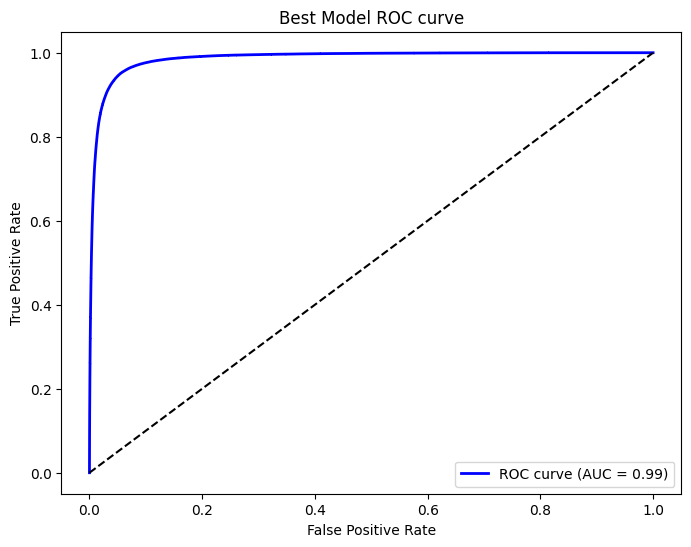

In [180]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Best Model")

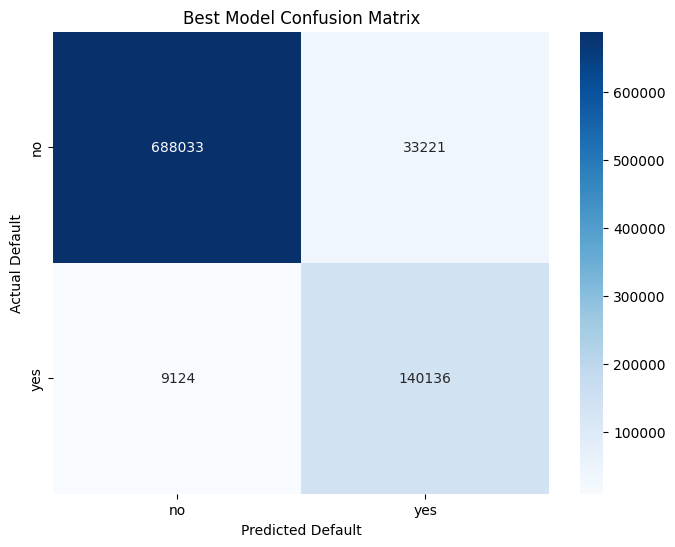

In [181]:
scoring_utils.get_confusion_matrix(y_total, yhat_total>best_cutoff, "Best Model")

In [192]:
predictions_df = pd.DataFrame(yhat_total, columns=['DefaultProbability'])
y_total_df = pd.DataFrame(y_total)

# Joining the DataFrames
result = pd.concat([
    X_total,
    y_total_df,
    predictions_df
], axis=1)

result = result.sort_values(by='DefaultProbability')

In [193]:
result.sample(10)

,Term,InterestRate,BankLoans,SBARatio,UrbanRural_0,RetainedJob,DisbursementGross,RevLineCr,SBA_Appv,Default,DefaultProbability
844523,84,5.40,28.0,0.80,True,0,99500.0,0,79600.0,0,0.007562
94956,64,5.50,1551.0,0.75,True,0,1000000.0,0,750000.0,0,0.429613
374925,240,6.27,413.0,0.75,False,0,178000.0,0,133500.0,0,0.001223
780936,120,5.80,61672.0,0.70,True,0,206000.0,0,144200.0,0,0.022081
70193,84,4.00,79723.0,0.50,False,5,50000.0,1,25000.0,0,0.009731
773824,180,5.74,61672.0,0.90,True,0,72000.0,0,126000.0,0,0.003315
692017,60,1.00,10921.0,0.85,False,0,36000.0,0,30600.0,0,0.005411
731204,84,1.76,22853.0,0.85,False,8,50000.0,0,42500.0,0,0.018705
364330,60,8.45,1050.0,0.90,True,0,60000.0,0,54000.0,0,0.132749
1777,300,5.39,3673.0,0.80,True,0,100000.0,0,80000.0,0,0.000839


In [199]:
# Start doing a coarse lookup for the best number of loans to accept
prop_selected_loans_list = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
best_loans_prop = 0
best_profit = 0

for prop_selected_loans in prop_selected_loans_list:
    n_accepted_loans = int(len(result)*prop_selected_loans)
    accepted_loans = result.head(n_accepted_loans)

    profit = scoring_utils.get_profit(accepted_loans, accepted_loans['Default'], np.zeros(n_accepted_loans))

    print(f"N loans: {n_accepted_loans}, profit: ${profit:,.2f}")

    if profit > best_profit:
        best_profit = profit
        best_loans_prop = prop_selected_loans



N loans: 0, profit: $0.00
N loans: 87051, profit: $1,968,613,341.10
N loans: 174102, profit: $3,035,398,065.45
N loans: 261154, profit: $3,704,144,437.40
N loans: 348205, profit: $4,357,544,201.00
N loans: 435257, profit: $5,049,758,464.85
N loans: 522308, profit: $5,793,137,504.20
N loans: 609359, profit: $6,561,486,629.65
N loans: 696411, profit: $7,208,032,400.45
N loans: 783462, profit: $5,937,646,077.60


With out model, we should accept 80.08% percent of the loans, or the 697108 least risky loans, generating a profit of $7,209,299,841.10.


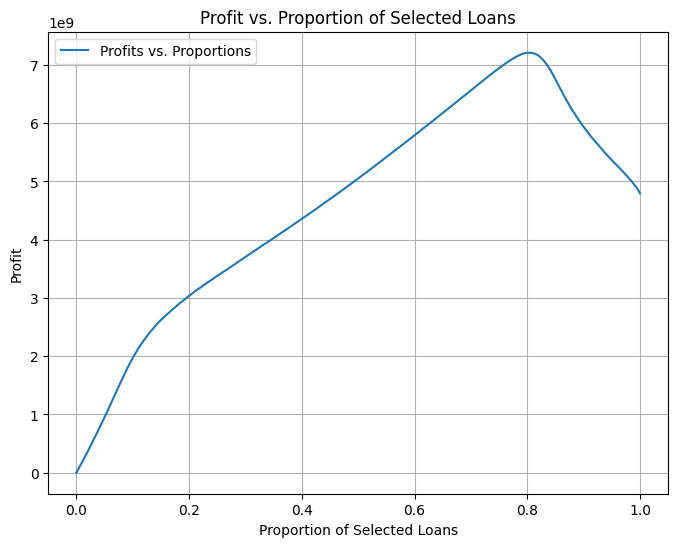

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of proportions to try
num_proportions = 1000  # Choose the number of proportions to try
prop_selected_loans_list = np.linspace(0, 1, num=num_proportions)

# Initialize arrays to store profits and selected proportions
profits = []
selected_proportions = []

best_loans_prop = 0
best_profit = 0

for prop_selected_loans in prop_selected_loans_list:
    n_accepted_loans = int(len(result) * prop_selected_loans)
    accepted_loans = result.head(n_accepted_loans)

    profit = scoring_utils.get_profit(
        accepted_loans, accepted_loans['Default'], np.zeros(n_accepted_loans)
    )

    profits.append(profit)
    selected_proportions.append(prop_selected_loans)

    if profit > best_profit:
        best_profit = profit
        best_loans_prop = prop_selected_loans

print(f"With out model, we should accept {best_loans_prop*100:.2f}% percent of the loans, or the {int(best_loans_prop*len(result))} least risky loans, generating a profit of ${best_profit:,.2f}.")

# Plotting the profits for each proportion
plt.figure(figsize=(8, 6))
plt.plot(selected_proportions, profits, label='Profits vs. Proportions')
plt.xlabel('Proportion of Selected Loans')
plt.ylabel('Profit')
plt.title('Profit vs. Proportion of Selected Loans')
plt.legend()
plt.grid(True)
plt.show()


With out model, we should accept 80.13% percent of the loans, or the 697547 least risky loans, generating a profit of $7,209,306,030.15.


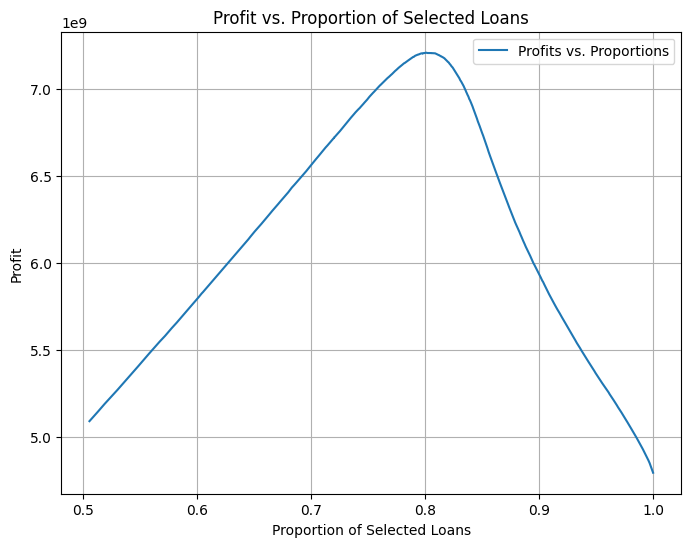

In [206]:
# Define the range of proportions to try
num_proportions = 1000  # Choose the number of proportions to try

# Generate proportions centered around 0.8 using a normal distribution
prop_selected_loans_mean = 0.8
prop_selected_loans_std = 0.1  # You can adjust the standard deviation as needed
prop_selected_loans_list = np.random.normal(prop_selected_loans_mean, prop_selected_loans_std, size=num_proportions)
prop_selected_loans_list = np.clip(prop_selected_loans_list, 0, 1)  # Clip values to ensure they are between 0 and 1

prop_selected_loans_list = np.sort(prop_selected_loans_list)

# Initialize arrays to store profits and selected proportions
profits = []
selected_proportions = []

best_loans_prop = 0
best_profit = 0

for prop_selected_loans in prop_selected_loans_list:
    n_accepted_loans = int(len(result) * prop_selected_loans)
    accepted_loans = result.head(n_accepted_loans)

    profit = scoring_utils.get_profit(
        accepted_loans, accepted_loans['Default'], np.zeros(n_accepted_loans)
    )

    profits.append(profit)
    selected_proportions.append(prop_selected_loans)

    if profit > best_profit:
        best_profit = profit
        best_loans_prop = prop_selected_loans

print(f"With out model, we should accept {best_loans_prop*100:.2f}% percent of the loans, or the {int(best_loans_prop*len(result))} least risky loans, generating a profit of ${best_profit:,.2f}.")

# Plotting the profits for each proportion
plt.figure(figsize=(8, 6))
plt.plot(selected_proportions, profits, label='Profits vs. Proportions')
plt.xlabel('Proportion of Selected Loans')
plt.ylabel('Profit')
plt.title('Profit vs. Proportion of Selected Loans')
plt.legend()
plt.grid(True)
plt.show()